This notebook contains the complete workflow of how to go from your files with genomic regions and measurements/labels of genomic features to files that can be input into MAGGIE. The main steps are as below:

    peak file/bed file with annotation -> differential peaks -> FASTA files -> MAGGIE
    
   1. Start with a peak file (HOMER format) or a bed file, which have annotations of the genomic feature of your interest at the last few columns. Annotation can be counts of reads/tags within peaks (i.e., reads-enriched regions) or boolean labels indicating the presence and absence of genomic feature
   2. Call differential peaks based on the reads counts by setting a threshold or based on presence and absence of certain labels. 
   3. Extract sequences for these differential regions from the genomes of comparative samples -> fasta file 1 and fasta file 2
   4. Input two fasta files to MAGGIE and obtain functional motifs for the genomic feature of your interest!

The tutorial starts here. First of all, let's load packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from Bio import Seq, motifs

import sys
sys.path.append('..') # add the path of 'maggie' package
from maggie import score, utils, visual # import 'maggie' package and functions

import os
import fnmatch

# Step 1: peak file --> differential peaks

### Read peak file

In [2]:
data_path = './data/mouse_strains_PU1/'
peak_file = 'mouse_strains_PU1_merged_annotated.txt'
peak_df = pd.read_csv(data_path+peak_file, sep='\t', index_col=0)
peak_df.index.name = None

### filter for regular chromosomes

In [3]:
include_chromosome = ['chr'+str(k) for k in np.arange(1,20)]
peak_df = peak_df.loc[np.any([np.array(peak_df.iloc[:,0] == i) for i in include_chromosome], axis=0)]
labels = peak_df.iloc[:,-2:]

### filter by minimum tags/reads

In [8]:
min_reads = 10
minTag_bools = labels.max(axis=1) >= min_reads
filtered_df = peak_df.loc[minTag_bools]
print('After tag filtering:', len(filtered_df))

After tag filtering: 93888


### define differential regions with preset cutoff

In [9]:
fc_cutoff = 1 # preset cutoff on the fold change of tags

In [10]:
filtered_labels = filtered_df.iloc[:,-2:]
filtered_labels = np.log2(filtered_labels+1)
label_fc = filtered_labels.iloc[:,0] - filtered_labels.iloc[:,1]
# specific for the 1st sample
spec_bools = label_fc > fc_cutoff
spec_df1 = filtered_df.loc[spec_bools]
print(filtered_labels.columns.values[0], len(spec_df1))

# specific for the 2nd sample
spec_bools = label_fc < -fc_cutoff
spec_df2 = filtered_df.loc[spec_bools]
print(filtered_labels.columns.values[1], len(spec_df2))

BALBC 4318
C57Bl6 3950


### scale all regions to the same size and save to files

In [11]:
scaled_size = 200

In [12]:
for n, spec_df in enumerate([spec_df1, spec_df2]):
    # scale region size
    index = ['_'.join(row[1][:3].astype(str)) for row in spec_df.iterrows()]
    spec_df.index = index
    mid_points = ((spec_df.iloc[:,1]+spec_df.iloc[:,2])/2).astype(int)
    spec_df.iloc[:,1] = mid_points - int(scaled_size/2)
    spec_df.iloc[:,2] = mid_points + int(scaled_size/2)

    # save to file
    output_file = peak_file.replace('.txt', '_spec'+str(n)+'.txt')
    spec_df.to_csv(data_path+output_file, sep='\t')

/gpfs/data01/glasslab/home/zes017/.conda/envs/maggie/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Step 2: differential peaks --> FASTA files

Before extracting sequences based on differential peaks, need to download the corresponding genomes first, which include mouse strains C57Bl6 (mm10) and BALBC

In [24]:
%%bash
mkdir ./data/genomes/ #make a folder that will be used to store genome files
cd ./data/genomes/
wget http://homer.ucsd.edu/maggie/downloads/genomes/BALBC.tar.gz
wget http://homer.ucsd.edu/maggie/downloads/genomes/C57BL6.tar.gz

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Unzip genome files

In [25]:
%%bash
cd ./data/genomes/
tar -zxvf BALBC.tar.gz
tar -zxvf C57BL6.tar.gz

BALBC/
BALBC/chr16_allele_1.mut
BALBC/chr7_allele_1.ref_to_strain.vector
BALBC/chr8_allele_1.mut
BALBC/chr2_allele_1.ref_to_strain.vector
BALBC/chr16_allele_1.fa
BALBC/chr16_allele_1.strain_to_ref.vector
BALBC/chr15_allele_1.strain_to_ref.vector
BALBC/last_shift_ref.txt
BALBC/chr3_allele_1.fa
BALBC/chr18_allele_1.strain_to_ref.vector
BALBC/chr19_allele_1.strain_to_ref.vector
BALBC/chr13_allele_1.mut
BALBC/chr18_allele_1.mut
BALBC/lookup_table_chr.txt
BALBC/chr2_allele_1.fa
BALBC/chr15_allele_1.ref_to_strain.vector
BALBC/chr15_allele_1.mut
BALBC/chr1_allele_1.fa
BALBC/chr10_allele_1.fa
BALBC/chrY_allele_1.fa
BALBC/chrX_allele_1.strain_to_ref.vector
BALBC/chr9_allele_1.strain_to_ref.vector
BALBC/chr16_allele_1.ref_to_strain.vector
BALBC/chr8_allele_1.strain_to_ref.vector
BALBC/chr10_allele_1.strain_to_ref.vector
BALBC/chrX_allele_1.mut
BALBC/chr17_allele_1.strain_to_ref.vector
BALBC/chr7_allele_1.mut
BALBC/chr14_allele_1.mut
BALBC/chr11_allele_1.mut
BALBC/chr4_allele_1.fa
BALBC/chrX_alle

Extract sequences using a script that consider the shift of genome coordinates across samples

In [26]:
%%bash
genome_dir='./data/genomes/' # specify the folder where genome files are stored
# extract sequences for BALBC-specific peaks
file1='./data/mouse_strains_PU1/mouse_strains_PU1_merged_annotated_spec0.txt'
file1_out_ref=$(echo $file1 | sed 's/.txt/_ref.fa/g')
perl extract_seq_from_peakfiles.pl -ind BALBC -file $file1 -data_dir $genome_dir -output $file1_out_ref &
file1_out_alt=$(echo $file1 | sed 's/.txt/_alt.fa/g')
perl extract_seq_from_peakfiles.pl -ind C57Bl6 -file $file1 -data_dir $genome_dir -output $file1_out_alt &
 
# extract sequences for C57Bl6-specific peaks
file2='./data/mouse_strains_PU1/mouse_strains_PU1_merged_annotated_spec1.txt'
file2_out_ref=$(echo $file2 | sed 's/.txt/_ref.fa/g')
perl extract_seq_from_peakfiles.pl -ind C57Bl6 -file $file2 -data_dir $genome_dir -output $file2_out_ref &
file2_out_alt=$(echo $file2 | sed 's/.txt/_alt.fa/g')
perl extract_seq_from_peakfiles.pl -ind BALBC -file $file2 -data_dir $genome_dir -output $file2_out_alt &


Saving peaks
This it is: ./data/mouse_strains_PU1/mouse_strains_PU1_merged_annotated_spec1.txt
Saving peaks
This it is: ./data/mouse_strains_PU1/mouse_strains_PU1_merged_annotated_spec0.txt
Saving peaks
This it is: ./data/mouse_strains_PU1/mouse_strains_PU1_merged_annotated_spec0.txt
Saving peaks
This it is: ./data/mouse_strains_PU1/mouse_strains_PU1_merged_annotated_spec1.txt
Loading shift vectors
Can't open ./data/genomes//C57BL6/chr_allele_1.fa
Exclude chromosome  allele 1 from analysis
Loading shift vectors
Loading shift vectors
Loading shift vectors
Can't open ./data/genomes//C57BL6/chr_allele_1.fa
Exclude chromosome  allele 1 from analysis
Can't open ./data/genomes//BALBC/chr_allele_1.fa
Exclude chromosome  allele 1 from analysis
Can't open ./data/genomes//BALBC/chr_allele_1.fa
Exclude chromosome  allele 1 from analysis


# Step 3: FASTA files --> MAGGIE

### read in motif files

In [14]:
motif_dict = score.load_motifs('JASPAR2018_CORE_vertebrates_non-redundant_pfms_jaspar/', 
                               pseudocounts=0.01)

### concatenate FASTA files

In [15]:
data_path = './data/mouse_strains_PU1/'
orig_fasta_files = np.sort(fnmatch.filter(os.listdir(data_path), '*spec*ref.fa'))
mut_fasta_files = np.sort(fnmatch.filter(os.listdir(data_path), '*spec*alt.fa'))
utils.cat_fasta_files([data_path+f for f in orig_fasta_files], [data_path+f for f in mut_fasta_files], 
                      output_name=data_path+'concat_files')

Successfully concatenate files ['./data/mouse_strains_PU1/mouse_strains_PU1_merged_annotated_spec0_ref.fa', './data/mouse_strains_PU1/mouse_strains_PU1_merged_annotated_spec1_ref.fa'] to: ./data/mouse_strains_PU1/concat_files_ref.fa
Successfully concatenate files ['./data/mouse_strains_PU1/mouse_strains_PU1_merged_annotated_spec0_alt.fa', './data/mouse_strains_PU1/mouse_strains_PU1_merged_annotated_spec1_alt.fa'] to: ./data/mouse_strains_PU1/concat_files_mut.fa


### Read FASTA files

In [16]:
orig_seq_dict = utils.read_fasta(data_path+'concat_files_ref.fa')
mut_seq_dict = utils.read_fasta(data_path+'concat_files_mut.fa')
print(len(orig_seq_dict), len(mut_seq_dict))

8268 8268


### Test on one specific motif

In [17]:
compute_motif = 'SPI1'
res = score.test_one_motif(motif_dict[compute_motif], orig_seq_dict, mut_seq_dict, 1)

MAGGIE results for motif SPI1:
-log10(p-value): 157.128193 (90% CI [145.071122, 168.349306])


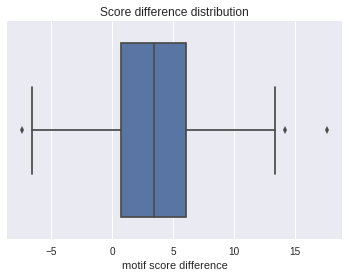

In [18]:
print('MAGGIE results for motif %s:' % (res[0]))
print('-log10(p-value): %f (90%% CI [%f, %f])' % (np.mean(res[2]), 
                                                  np.percentile(res[2], 5), np.percentile(res[2], 95)))
score_diff = np.array(res[3])
sns.boxplot(score_diff[score_diff!=0])
plt.title('Score difference distribution');
plt.xlabel('motif score difference');

### Test on all motifs

In [19]:
results = score.test_all_motifs(motif_dict, orig_seq_dict, mut_seq_dict, 
                                top_site=1, p=30) #specify number of cores used for computation, the more the faster
results.to_csv(data_path+'maggie_output/maggie_output.tsv', sep='\t')

### Merge similar motifs based on correlation of score differences

In [20]:
merge_stats = score.combine_similar_motifs(results, 0.6) # merge motifs whose score differences have pearson correlation over 0.6
print(merge_stats.shape)
merge_stats.to_csv(data_path+'maggie_output/maggie_output_merged.tsv', sep='\t')

(246, 6)


### Show significant motifs

In [21]:
alpha = 5e-2
sig_motifs = utils.FDR_cutoff(np.abs(merge_stats['Median p-val']), alpha=alpha)
print(len(sig_motifs))
merge_stats.loc[sig_motifs].to_csv(data_path+'maggie_output/maggie_output_mergedSignificant.tsv', sep='\t')

42


### Generate visualization of significant motifs

In [22]:
visual.save_logos(motif_dict, folder='./data/mouse_strains_PU1/maggie_output/')
visual.generate_html(folder='./data/mouse_strains_PU1/maggie_output/')

Successfully saved motif logos


Now, you can go to the folder './data/mouse_strains_PU1/maggie_output/' and open the HTML file to view significant motifs functional for PU.1 binding!